## Basic Settings

In [1]:
!pip install causalml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1


In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import requests

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.inference.tf import DragonNet
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset.regression import *
from causalml.metrics import *

import os, sys

%matplotlib inline

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
sns.set_palette('Paired')
plt.rcParams['figure.figsize'] = (12,8)

## Read Data

In [7]:
local_path = "ihdp_npci_3.csv"
urls = [
    "https://raw.githubusercontent.com/uber/causalml/master/docs/examples/data/ihdp_npci_3.csv",
    "https://raw.githubusercontent.com/claudiashi57/dragonnet/master/dat/ihdp_npci_3.csv",
]

if not os.path.exists(local_path):
    for u in urls:
        try:
            r = requests.get(u, timeout=10)
            if r.ok and len(r.content) > 0:
                with open(local_path, "wb") as f:
                    f.write(r.content)
                break
        except Exception:
            pass


In [8]:
# CSV 읽기 (헤더 없음)
df = pd.read_csv(local_path, header=None)
cols = ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [f"x{i}" for i in range(1, 26)]
df.columns = cols


In [9]:
df.shape

(747, 30)

In [11]:
df.head()

,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,1,5.931652,3.500591,2.253801,7.136441,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,1,0,0,0,0,0,0
1,0,2.175966,5.952101,1.257592,6.553022,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
2,0,2.180294,7.175734,2.384100,7.192645,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
3,0,3.587662,7.787537,4.009365,7.712456,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
4,0,2.372618,5.461871,2.481631,7.232739,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0


In [12]:
pd.Series(df['treatment']).value_counts(normalize=True)
# T = 0이 80%를 차지

,proportion
treatment,
0,0.813922
1,0.186078


## DragonNet

Reference: https://arxiv.org/pdf/1906.02120

- Motivation:
	1.	모형 적합: (i) 결과 모델(Outcome model)과 (ii) 처치 확률 모형(Propensity score model)을 적합.
	2.	효과 추정: 적합된 모형들을 이용해 ATE, ITE 등의 처치 효과를 추정.
  => 이 중 모형 적합 단계에서 신경망을 어떻게 설계/훈련해야 최종 효과 추정의 정확도가 높아질까?


- **DragonNet 아키텍처**:
  증명된 Thm에 의해서 ATE 추정을 할때 X 전체 값 대신 g(X) 만 사용해도 충분하다. 다시 말해, X에는 두 가지 정보가 있는데:
	1.	처치 배정을 설명하는 정보 (propensity와 관련된 부분)
	2.	결과 예측에는 도움되지만 처치 배정과 무관한 정보
	-> 인과 효과 추정에서는 (1)만 필요하고, (2)는 오히려 혼동(noise)을 일으켜 finite-sample 성능을 해칠 수 있음
  
  -> 즉, outcome prediction accuracy에 도움 되더라도 causal effect estimation에는 불필요할 수 있음.


  -> X -> Z(X)로 표현하는 NN을 학습한 후 3곳에 활용.
  1. Propensity score head $\hat g(X)$ - 성향점수 반영을 강제하기 위함.
  2. Outcome head for treated ($\hat Q(1, X)$)
  3. Outcome head for control ($\hat Q(0, X)$)

  손실함수 역시 outcome 손실 (MSE)와 propensity score 손실 (cross entropy)를 동시에 반영.

  $$
  \hat R(\theta; X) = \frac{1}{n}\sum_i \Big[ (Q^{nn}(t_i, x_i; \theta) - y_i)^2 + \alpha \, \text{CrossEntropy}(g^{nn}(x_i; \theta), t_i) \Big].
  $$

  최종 ATE는:
  $$
  \hat \psi^Q = \mathbb{E}[\hat Q(1, X)] - \mathbb{E}[\hat Q(0, X)]
  $$
---
  - Targeted Regularization: NN은 기본적으로 예측을 위한 모델이기 때문에 인과 추정에는 적합하지 않다. 따라서, '추가 항'을 넣어 세미파라메트릭 효율 추정량 조건(3.1)을 만족하도록 손실함수를 수정해야함.

  $$
  Q(t_i, x_i; \theta, \epsilon) = Q^{nn}(t_i, x_i; \theta) + \epsilon \Big[ \frac{t_i}{g^{nn}(x_i; \theta)} - \frac{1-t_i}{1-g^{nn}(x_i; \theta)} \Big]
  $$

  $$
  R(y_i, t_i, x_i; \theta, \epsilon) = (y_i - Q(t_i, x_i; \theta, \epsilon))^2
  $$

  -> propensity score ($\hat{g}$) 기반의 보정항이 추가됨.

  $$
  \hat \theta, \hat \epsilon = \arg\min_{\theta, \epsilon} \bigg( \hat R(\theta; X) + \beta \frac{1}{n} \sum_i R(y_i, t_i, x_i; \theta, \epsilon) \bigg)
  $$
  
  최종 ATE는:
  $$
  \hat \psi^{treg} = \frac{1}{n} \sum_i \Big( \hat Q^{treg}(1, x_i) - \hat Q^{treg}(0, x_i) \Big)
  $$

## DragonNet + Meta-learner Comparison (IHDP Dataset)

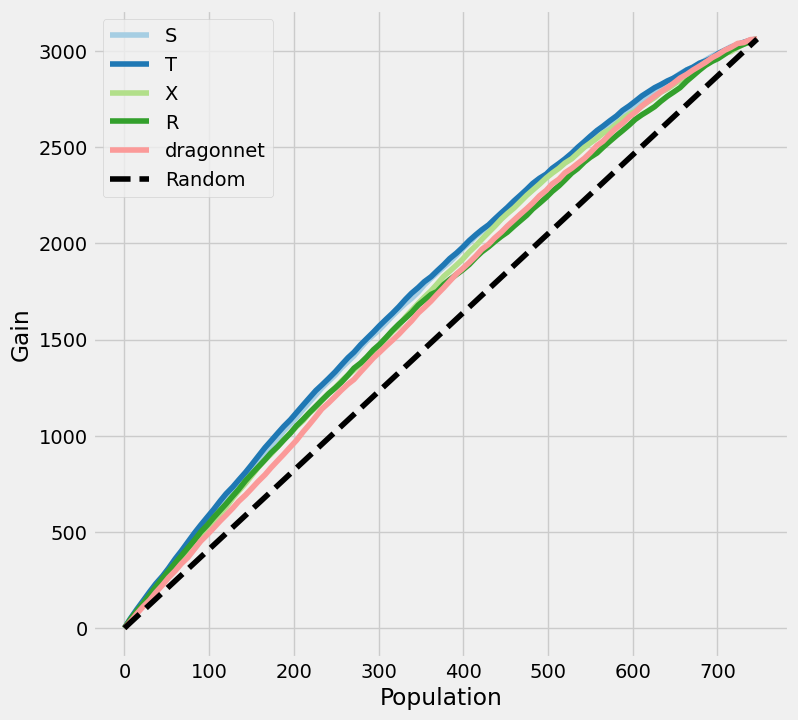

In [26]:
X = df.loc[:,'x1':]
A = df['treatment']
y = df['y_factual']

# 실제 tau / ate 값
tau = df.apply(lambda d: d['y_factual'] - d['y_cfactual'] if d['treatment']==1
               else d['y_cfactual'] - d['y_factual'],
               axis=1)
ate = tau.mean()

In [27]:
dragon = DragonNet(neurons_per_layer=200, targeted_reg=True)
dragon_ite = dragon.fit_predict(X, A, y, return_components=False)
dragon_ate = dragon_ite.mean()

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - binary_classification_loss: 39.4016 - loss: 1640.1171 - regression_loss: 788.9432 - track_epsilon: 0.0356 - treatment_accuracy: 0.8062 - val_binary_classification_loss: 35.9049 - val_loss: 508.9366 - val_regression_loss: 185.6586 - val_track_epsilon: 0.0336 - val_treatment_accuracy: 0.6600 - learning_rate: 0.0010
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - binary_classification_loss: 28.8928 - loss: 325.8730 - regression_loss: 141.4126 - track_epsilon: 0.0331 - treatment_accuracy: 0.8507 - val_binary_classification_loss: 36.4973 - val_loss: 273.8192 - val_regression_loss: 99.0470 - val_track_epsilon: 0.0305 - val_treatment_accuracy: 0.6600 - learning_rate: 0.0010
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - binary_classification_loss: 27.0455 - loss: 298.5774 - regression_loss: 134.2719 - track_epsilon: 0.0304 - treatment_accuracy: 0.8616 - val_binary_classification_loss: 38.5181 - val_loss: 251.4021 - val_regression

In [28]:
# 다른 비교 모델

## 우선 성향점수를 ElasticNet으로 처리
p_model = ElasticNetPropensityModel()
p = p_model.fit_predict(X, A)

# S, T, X, R
s_learner = BaseSRegressor(LGBMRegressor())
s_ate = s_learner.estimate_ate(X, A, y)[0]
s_ite = s_learner.fit_predict(X, A, y)

t_learner = BaseTRegressor(LGBMRegressor())
t_ate = t_learner.estimate_ate(X, A, y)[0][0]
t_ite = t_learner.fit_predict(X, A, y)

x_learner = BaseXRegressor(LGBMRegressor())
x_ate = x_learner.estimate_ate(X, A, y, p)[0][0]
x_ite = x_learner.fit_predict(X, A, y, p)

r_learner = BaseRRegressor(LGBMRegressor())
r_ate = r_learner.estimate_ate(X, A, y, p)[0][0]
r_ite = r_learner.fit_predict(X, A, y, p)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 747, number of used features: 26
[LightGBM] [Info] Start training from score 4.046921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [33]:
df_preds = pd.DataFrame([s_ite.ravel(),
                          t_ite.ravel(),
                          x_ite.ravel(),
                          r_ite.ravel(),
                          dragon_ite.ravel(),
                          tau.ravel(),
                          A.ravel(),
                          y.ravel()],
                       index=['S','T','X','R','dragonnet','tau','w','y']).T

df_cumgain = get_cumgain(df_preds)

In [34]:
df_result = pd.DataFrame([s_ate, t_ate, x_ate, r_ate, dragon_ate, tau.mean()],
                     index=['S','T','X','R','dragonnet','actual'], columns=['ATE'])
df_result['MAE'] = [mean_absolute_error(t,p) for t,p in zip([s_ite, t_ite, x_ite, r_ite, dragon_ite],
                                                            [tau.values.reshape(-1,1)]*5 )
                ] + [None]
df_result['AUUC'] = auuc_score(df_preds)


In [35]:
df_result

# 모두 실제 ATE (4.09) 와 유사하게 추정.
# MAE 기준으로는 T-learner가 가장 우수함.

,ATE,MAE,AUUC
S,4.054511,1.027666,0.575822
T,4.100199,0.980788,0.580929
X,4.017526,1.117571,0.564378
R,4.110686,1.700770,0.556276
dragonnet,4.019654,1.195620,0.552730
actual,4.098887,NaN,NaN


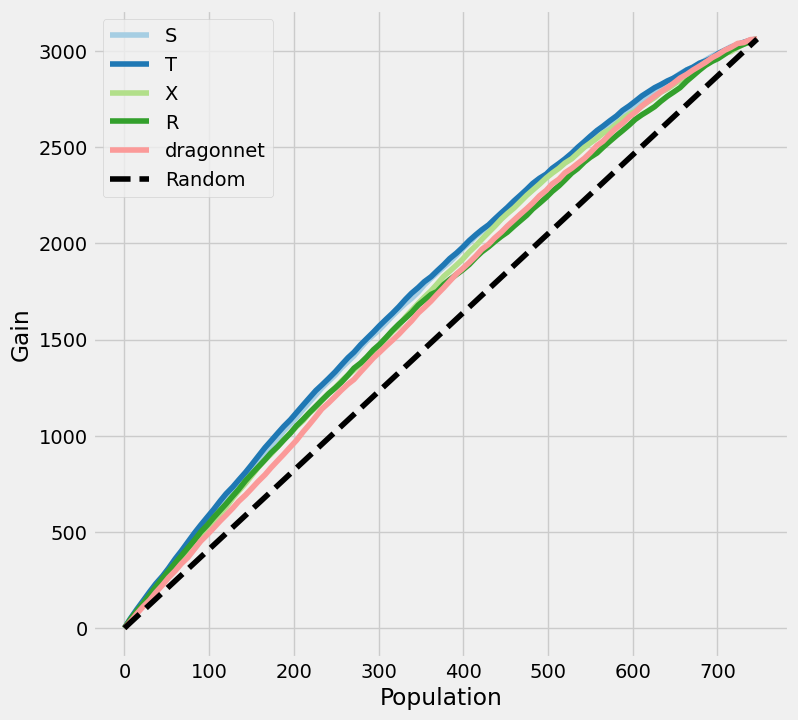

In [32]:
plot_gain(df_preds)

## DragonNet vs. Meta-Learner

https://arxiv.org/pdf/1906.02120 (p. 10-11)

-  Outcome prediction 성능 < Estimation 성능: outcome 예측을 위한 정보를 일부 버리고 treatment-relevant representation에 맞춰 학습되기 때문.
- Covariates 중 T와 무관한 Y-only 변수 제거 효과: 따라서 covariates 중 “Y에는 영향 주지만 T와 무관한” 변수들은 confounding에 불필요한 noise로 간주되어 자동으로 버려짐. (즉, **confounder 개수가 많을수록** DragonNet의 상대적 장점 커짐)
- 작은 (유한한) 데이터에서의 강점: confounding과 무관한 covariates를 버려서 representation을 더 잘 정제함.	따라서 다른 딥러닝 기반 모델에 비해 **비교적 작은 데이터셋에서도 효과 추정 안정성이 개선됨.**


| **상황**           | **DragonNet 추천**                                   | **Meta-learner 추천**                                      |
|---------------------|-----------------------------------------------------|------------------------------------------------------------|
| **데이터 크기**     | 소규모, 중간 샘플 (finite-sample bias 우려)         | 대규모 샘플 (신경망 학습 충분, variance↓)                  |
| **Covariate 구조**  | confounder 많고 Y-only 잡음 변수 많은 경우          | confounder 적거나 구조 단순                                |
| **목표**            | ATE 추정의 bias/efficiency 개선                      | ITE ranking / uplift 타겟팅                                |
| **Propensity**      | 잘 모르거나 모델에 representation으로 포함시켜야 할 때 | 명확히 추정 가능할 때 (예: RCT 또는 간단한 PS 모델)        |
| **안정성/재현성**   | 연구 setting에서 최적화 가능, 복잡한 인과 구조        | 현업 적용에서 안정적 baseline 필요                         |
| **해석성**          | 블랙박스라도 상관없음                               | 단순, 해석력 중요할 때                                    |




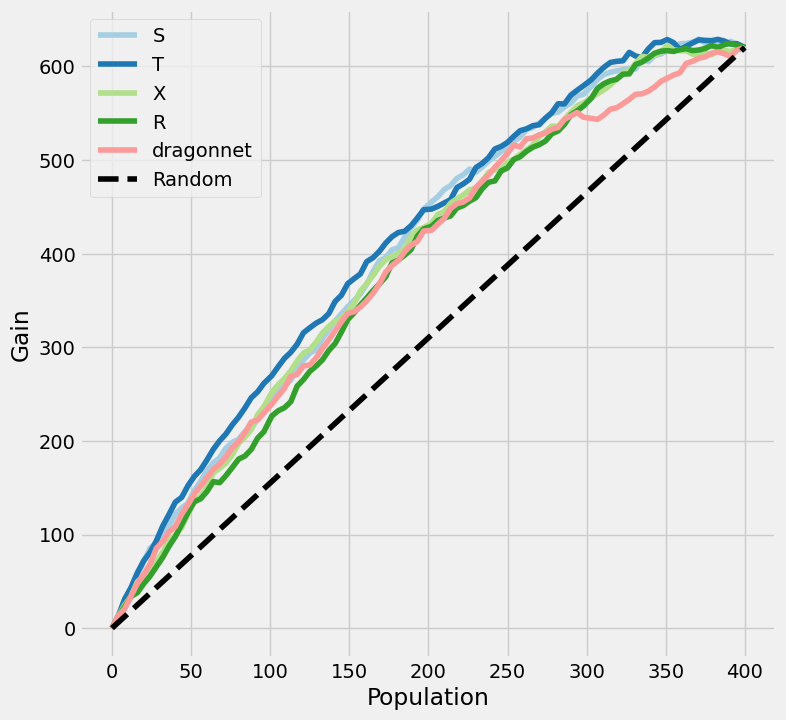

In [65]:
import numpy as np
import pandas as pd

def make_synth_dragonnet(
    n=400,
    d_conf=6,
    d_yonly=80,
    d_noise=80,
    g_strength=2.5,
    seed=42
):
    """
    DragonNet-friendly synthetic data:
      - Treatment depends ONLY on confounders (propensity sufficiency)
      - Outcome depends on confounders + many Y-only vars
      - Outcome additionally depends NONLINEARLY on g(X) (propensity),
    Returns df with ['treatment','y_factual','y_cfactual','x1'..]
    """
    rng = np.random.default_rng(seed)

    # 1) Covariates
    X_conf  = rng.normal(size=(n, d_conf))
    X_yonly = rng.normal(size=(n, d_yonly))
    X_noise = rng.normal(size=(n, d_noise))
    X = np.concatenate([X_conf, X_yonly, X_noise], axis=1)
    d_total = X.shape[1]

    # 2) Propensity p(x): ONLY confounders (nonlinear), keep overlap
    b = rng.normal(0.6, 0.3, size=d_conf)
    z_lin = X_conf @ b
    z_int = 0.8*np.sin(X_conf[:,0]) + 0.6*(X_conf[:,1]*X_conf[:,2]) - 0.5*np.tanh(X_conf[:,3])
    logits = 0.6*z_lin + z_int
    # narrower but safe overlap (≈ 0.15~0.85)
    p = 0.15 + 0.7*(1/(1+np.exp(-logits)))
    A = rng.binomial(1, p)

    # 3) Baseline outcome mu0(x): confounders + Y-only + g(X) term
    g_conf = 1.2*np.tanh(X_conf[:,0]) + 0.8*np.sin(X_conf[:,1]) - 0.6*(X_conf[:,2]**2)/3
    # Y-only: 여러 차원을 약하게 합쳐 변동성↑
    yonly_block1 = 0.9*np.sin(X_yonly[:,0]) + 0.5*np.tanh(X_yonly[:,1]) + 0.4*X_yonly[:,2]
    yonly_block2 = 0.15*X_yonly[:, 3:].sum(axis=1) / max(1, (d_yonly-3))**0.5
    g_yonly = yonly_block1 + yonly_block2
    g_term = g_strength * ( (p - 0.5)**2 + 0.4*np.sin(3*np.pi*p) )

    mu0 = 1.5 + g_conf + g_yonly + g_term

    # 4) Heterogeneous treatment effect: confounders only
    tau = (
        1.6
        + 1.3*np.tanh(0.7*X_conf[:,0] - 0.5*X_conf[:,4])
        + 1.0*np.sin(X_conf[:,1] + X_conf[:,3])
    )

    # 5) Potential outcomes + noise
    sigma0, sigma1 = 0.9, 0.9
    eps0 = rng.normal(0, sigma0, size=n)
    eps1 = rng.normal(0, sigma1, size=n)
    y0 = mu0 + eps0
    y1 = mu0 + tau + eps1

    # 6) Factual / counterfactual
    y_factual   = A*y1 + (1-A)*y0
    y_cfactual  = A*y0 + (1-A)*y1

    # 7) Pack DataFrame
    cols = {f'x{i+1}': X[:, i] for i in range(d_total)}
    df = pd.DataFrame({
        'treatment': A.astype(int),
        'y_factual': y_factual,
        'y_cfactual': y_cfactual,
        **cols
    })
    return df

# 사용 예:
df = make_synth_dragonnet()
df.head()

,treatment,y_factual,y_cfactual,x1,x2,x3,x4,x5,x6,x7,...,x157,x158,x159,x160,x161,x162,x163,x164,x165,x166
0,0,0.759556,5.415814,0.304717,-1.039984,0.750451,0.940565,-1.951035,-1.302180,-0.446069,...,0.657971,0.812391,1.429790,0.953925,-0.603027,-0.390201,0.838758,0.389708,-0.017826,-0.874721
1,1,4.635405,0.638346,0.127840,-0.316243,-0.016801,-0.853044,0.879398,0.777792,1.816527,...,0.852300,2.020296,-0.781615,0.135443,-0.990708,-0.102209,0.720095,1.127336,-0.382260,-1.204786
2,0,2.686648,7.330900,0.066031,1.127241,0.467509,-0.859292,0.368751,-0.958883,0.358956,...,-0.675497,-1.428666,0.153345,0.331362,0.892913,0.267318,1.053989,1.074499,-1.028096,-0.518063
3,1,3.934378,2.902525,0.878450,-0.049926,-0.184862,-0.680930,1.222541,-0.154529,0.588640,...,0.534543,1.842195,2.675211,0.463329,-0.110394,0.440919,-0.232242,-1.587382,-0.046590,1.082117
4,1,0.198377,0.259333,-0.428328,-0.352134,0.532309,0.365444,0.412733,0.430821,0.175700,...,-0.420175,0.058453,-0.979437,-0.863972,-2.529151,0.456568,0.731520,1.085420,-1.102427,0.439909


In [66]:
X = df.loc[:,'x1':]
A = df['treatment']
y = df['y_factual']

# 실제 tau / ate 값
tau = df.apply(lambda d: d['y_factual'] - d['y_cfactual'] if d['treatment']==1
               else d['y_cfactual'] - d['y_factual'],
               axis=1)
ate = tau.mean()

In [67]:
dragon = DragonNet(neurons_per_layer=200, targeted_reg=True)
dragon_ite = dragon.fit_predict(X, A, y, return_components=False)
dragon_ate = dragon_ite.mean()

# 다른 비교 모델

## 우선 성향점수를 ElasticNet으로 처리
p_model = ElasticNetPropensityModel()
p = p_model.fit_predict(X, A)

# S, T, X, R
s_learner = BaseSRegressor(LGBMRegressor())
s_ate = s_learner.estimate_ate(X, A, y)[0]
s_ite = s_learner.fit_predict(X, A, y)

t_learner = BaseTRegressor(LGBMRegressor())
t_ate = t_learner.estimate_ate(X, A, y)[0][0]
t_ite = t_learner.fit_predict(X, A, y)

x_learner = BaseXRegressor(LGBMRegressor())
x_ate = x_learner.estimate_ate(X, A, y, p)[0][0]
x_ite = x_learner.fit_predict(X, A, y, p)

r_learner = BaseRRegressor(LGBMRegressor())
r_ate = r_learner.estimate_ate(X, A, y, p)[0][0]
r_ite = r_learner.fit_predict(X, A, y, p)


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 308ms/step - binary_classification_loss: 44.3846 - loss: 1019.2866 - regression_loss: 487.6787 - track_epsilon: 0.0258 - treatment_accuracy: 0.5668 - val_binary_classification_loss: 28.9083 - val_loss: 462.1891 - val_regression_loss: 167.4486 - val_track_epsilon: 0.0295 - val_treatment_accuracy: 0.4500 - learning_rate: 0.0010
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - binary_classification_loss: 43.3463 - loss: 455.4081 - regression_loss: 205.0549 - track_epsilon: 0.0305 - treatment_accuracy: 0.5870 - val_binary_classification_loss: 28.9893 - val_loss: 390.7973 - val_regression_loss: 135.2895 - val_track_epsilon: 0.0336 - val_treatment_accuracy: 0.4750 - learning_rate: 0.0010
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - binary_classification_loss: 42.5885 - loss: 277.5654 - regression_loss: 114.0285 - track_epsilon: 0.0342 - treatment_accuracy: 0.6095 - val_binary_classification_loss: 28.9989 - val_loss: 321.5540 - val_regression_los

In [68]:
df_preds = pd.DataFrame([s_ite.ravel(),
                          t_ite.ravel(),
                          x_ite.ravel(),
                          r_ite.ravel(),
                          dragon_ite.ravel(),
                          tau.ravel(),
                          A.ravel(),
                          y.ravel()],
                       index=['S','T','X','R','dragonnet','tau','w','y']).T

df_cumgain = get_cumgain(df_preds)

In [69]:
df_result = pd.DataFrame([s_ate, t_ate, x_ate, r_ate, dragon_ate, tau.mean()],
                     index=['S','T','X','R','dragonnet','actual'], columns=['ATE'])
df_result['MAE'] = [mean_absolute_error(t,p) for t,p in zip([s_ite, t_ite, x_ite, r_ite, dragon_ite],
                                                            [tau.values.reshape(-1,1)]*5 )
                ] + [None]
df_result['AUUC'] = auuc_score(df_preds)


In [70]:
df_result

,ATE,MAE,AUUC
S,0.998895,1.285146,0.647421
T,1.408578,1.280150,0.662679
X,1.267614,1.257167,0.633808
R,3.695429,3.774948,0.620976
dragonnet,1.592784,1.850558,0.622646
actual,1.550711,NaN,NaN


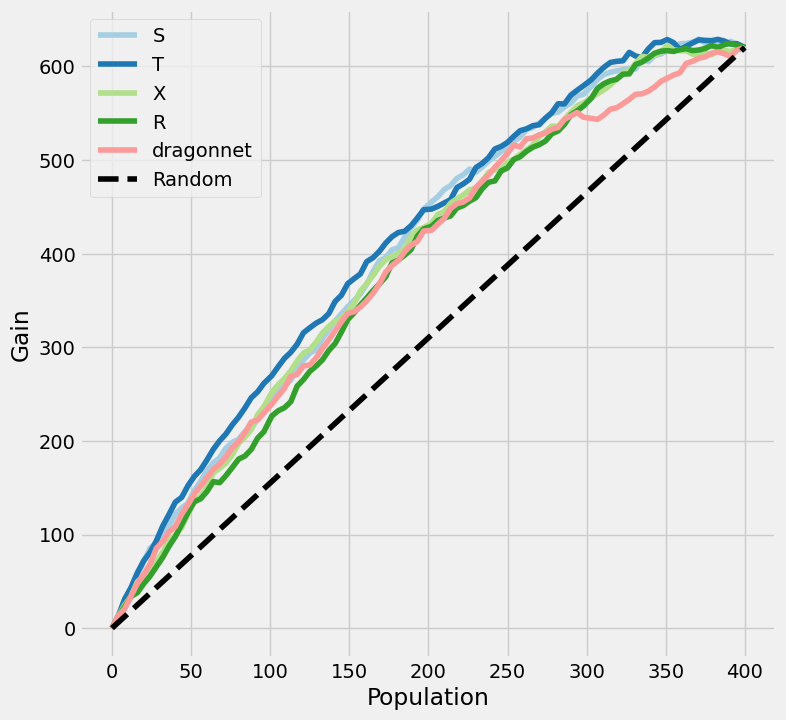

In [71]:
plot_gain(df_preds)
# AUUC에는 불리하나, ATE 추정을 잘 함.